<a href="https://colab.research.google.com/github/oceanhackweek/Oceans19-data-science-tutorial/blob/master/notebook/xarray_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xarray for multidimensional labeled data

Xarray is designed to make it easier to work with with _labeled multidimensional data_. By _multidimensional data_ (also often called _N-dimensional_), we mean data with many independent dimensions or axes. For example, we might represent Earth's surface temperature $T$ as a three dimensional variable

$$ T(x, y, t) $$

where $x$ and $y$ are spatial dimensions and and $t$ is time. By _labeled_, we mean data that has metadata associated with it describing the names and relationships between the variables. The cartoon below shows a "data cube" schematic dataset with temperature and preciptation sharing the same three dimensions, plus longitude and latitude as auxilliary coordinates.

![xarray data model](https://github.com/pydata/xarray/raw/master/doc/_static/dataset-diagram.png)

## Getting Help with Xarray

Here are some important resources for learning more about xarray and getting help.

- [Xarray Documentation](http://xarray.pydata.org/en/latest/)
- [Xarray GitHub Issue Tracker](https://github.com/pydata/xarray/issues)
- [Xarray questions on StackOverflow](https://stackoverflow.com/questions/tagged/python-xarray)

## Learning Goals for Xarray

#### Dataset Creation

1. Describe the core xarray data structures, the `DataArray` and the `Dataset`, and the components that make them up, including: Data Variables, Dimensions, Coordinates, Indexes, and Attributes
1. Create xarray `DataArray`s out of raw numpy arrays
1. Create xarray objects with and without indexes
1. Load xarray datasets from netCDF files
1. View and set attributes 

#### Indexing

1. Select data by position using `.isel` with values or slices
1. Select data by label using `.sel` with values or slices
1. Select timeseries data by date/time with values or slices
1. Use nearest-neighbor lookups with `.sel`

#### Computation

1. Do basic arithmetic with DataArrays and Datasets
1. Use numpy universal function on DataArrays and Datasets, or use corresponding built-in xarray methods
1. Combine multiple xarray objects in arithmetic operations and understand how they are broadcasted / aligned
1. Perform aggregation (reduction) along one or multiple dimensions of a DataArray or Dataset

#### Plotting

1. Use built-in xarray plotting for 1D and 2D DataArrays
1. Customize plots with options
1. Use cartopy together with xarray to create maps

#### Groupby, resample, and rolling

1. Use groupby to create climatologies and calculate anomalies.
1. Change the temporal resolution of data via resample and rolling.



## I. Xarray data structures

Like Pandas, xarray has two fundamental data structures:
* a `DataArray`, which holds a single multi-dimensional variable and its coordinates
* a `Dataset`, which holds multiple variables that potentially share the same coordinates

### DataArray

A `DataArray` has four essential attributes:
* `values`: a `numpy.ndarray` holding the array’s values
* `dims`: dimension names for each axis (e.g., `('x', 'y', 'z')`)
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings)
* `attrs`: an `OrderedDict` to hold arbitrary metadata (attributes)

Let's start by constructing some DataArrays manually 

In [1]:
!pip install wget
!pip install netcdf4

In [2]:
pip install xarray==0.14.0

In [0]:
import os
import tarfile
import wget


def get_sst_data(data_dir=None):
    if data_dir is None:
        data_dir = os.path.join(os.path.expanduser('~'), '.xarray_tutorial_data')
    
    os.makedirs(data_dir, exist_ok=True)

    remote = 'http://ldeo.columbia.edu/~rpa/sst.tar.gz'

    # download the data
    filename = wget.download(remote, out=data_dir)

    # un tar/zip the file
    cwd = os.getcwd()
    os.chdir(data_dir)
    try:
        with tarfile.open(filename, "r:gz") as file:
            file.extractall()
    finally:
        os.chdir(cwd)

    # remove tar.gz file
    os.remove(filename)

    print(f'\nsst data is in {data_dir}/sst')

In [4]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

#from utils import get_sst_data

plt.rcParams['figure.figsize'] = (8,5)

# get some sample data for later
get_sst_data()


sst data is in /root/.xarray_tutorial_data/sst


Here we model the simple function

$$f(x) = sin(x)$$

on the interval $-\pi$ to $\pi$. We start by creating the data as numpy arrays.

In [0]:
x = np.linspace(-np.pi, np.pi, 19)
f = np.sin(x)

Now we are going to put this into an xarray DataArray.

A simple DataArray without dimensions or coordinates isn't much use.

In [6]:
da_f = xr.DataArray(f)
da_f

<xarray.DataArray (dim_0: 19)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00,  3.42020143e-01,  6.42787610e-01,
        8.66025404e-01,  9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
        6.42787610e-01,  3.42020143e-01,  1.22464680e-16])
Dimensions without coordinates: dim_0

We can add a dimension name...

In [7]:
da_f = xr.DataArray(f, dims=['x'])
da_f

<xarray.DataArray (x: 19)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00,  3.42020143e-01,  6.42787610e-01,
        8.66025404e-01,  9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
        6.42787610e-01,  3.42020143e-01,  1.22464680e-16])
Dimensions without coordinates: x

But things get most interesting when we add a coordinate:

In [8]:
da_f = xr.DataArray(f, dims=['x'], coords={'x': x})
da_f

<xarray.DataArray (x: 19)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00,  3.42020143e-01,  6.42787610e-01,
        8.66025404e-01,  9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
        6.42787610e-01,  3.42020143e-01,  1.22464680e-16])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... 2.094 2.443 2.793 3.142

Xarray has built-in plotting, like pandas.

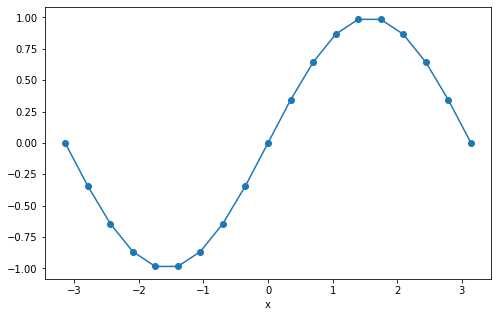

In [9]:
da_f.plot(marker='o')

### Selecting Data

We can always use regular numpy indexing and slicing on DataArrays to get the data back out.

In [10]:
# get the 10th item
da_f[10]

<xarray.DataArray ()>
array(0.34202014)
Coordinates:
    x        float64 0.3491

In [11]:
# git the first 10 items
da_f[:10]

<xarray.DataArray (x: 10)>
array([-1.22464680e-16, -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
       -9.84807753e-01, -9.84807753e-01, -8.66025404e-01, -6.42787610e-01,
       -3.42020143e-01,  0.00000000e+00])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... -0.6981 -0.3491 0.0

However, it is often much more powerful to use xarray's `.sel()` method to use label-based indexing. This allows us to fetch values based on the value of the coordinate, not the numerical index.

In [12]:
da_f.sel(x=0)

<xarray.DataArray ()>
array(0.)
Coordinates:
    x        float64 0.0

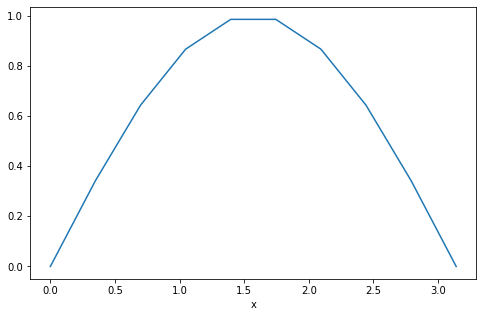

In [13]:
da_f.sel(x=slice(0, np.pi)).plot()

### Basic Computations

When we perform mathematical maniulpations of xarray DataArrays, the coordinates come along for the ride.
Imagine we want to calcuate

$$ g = f^2 + 1 $$

We can apply familiar numpy operations to xarray objects.


In [14]:
da_g = da_f**2 + 1
da_g

<xarray.DataArray (x: 19)>
array([1.        , 1.11697778, 1.41317591, 1.75      , 1.96984631,
       1.96984631, 1.75      , 1.41317591, 1.11697778, 1.        ,
       1.11697778, 1.41317591, 1.75      , 1.96984631, 1.96984631,
       1.75      , 1.41317591, 1.11697778, 1.        ])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... 2.094 2.443 2.793 3.142

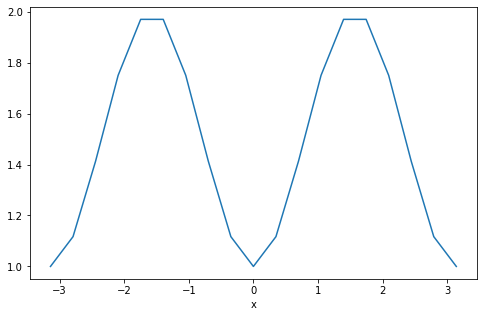

In [15]:
da_g.plot()

### Exercise

- Multipy the DataArrays `da_f` and `da_g` together.
- Select the range $-1 < x < 1$
- Plot the result

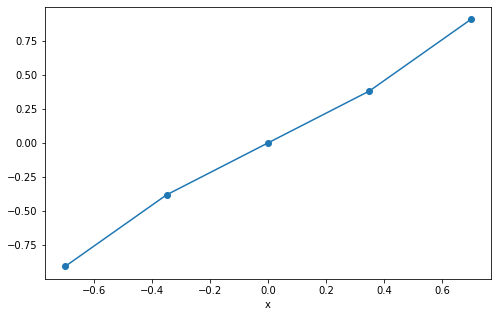

In [16]:
(da_f * da_g).sel(x=slice(-1, 1)).plot(marker='o')

## II. Multidimensional Data

If we are just dealing with 1D data, Pandas and Xarray have very similar capabilities. Xarray's real potential comes with multidimensional data.

At this point we will load data from a netCDF file into an xarray dataset.

In [17]:
ds = xr.open_dataset('/root/.xarray_tutorial_data/sst/NOAA_NCDC_ERSST_v3b_SST-1960.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 12)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 1960-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

### Datasets

We just created our first xarray `Dataset`. What is a dataset? A Dataset is simply an object wihich holds many DataArrays which potentially can share coordinates.

Datasets have three main elements:
- Data variables
- Coordiantes (which provide labels and other ancillary information about the data variables)
- Attributes (additional metadata for the dataset)

This dataset only contains one variable (`sst`), which we can access in the following two ways

In [18]:
# both do the exact same thing

# dictionary syntax
sst = ds['sst']

# attribute syntax
sst = ds.sst

sst

<xarray.DataArray 'sst' (time: 12, lat: 89, lon: 180)>
[192240 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 1960-12-15
Attributes:
    pointwidth:          1.0
    valid_min:           -3.0
    valid_max:           45.0
    units:               degree_Celsius
    long_name:           Extended reconstructed sea surface temperature
    standard_name:       sea_surface_temperature
    iridl:hasSemantics:  iridl:SeaSurfaceTemperature

### Multidimensional Indexing

In this example, we take advantage of the fact that xarray understands time to select a particular date

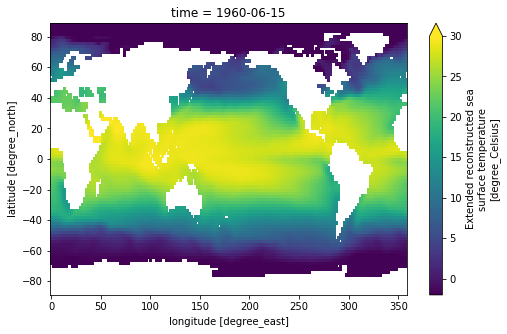

In [19]:
sst.sel(time='1960-06-15').plot(vmin=-2, vmax=30)

But we can select along any axis

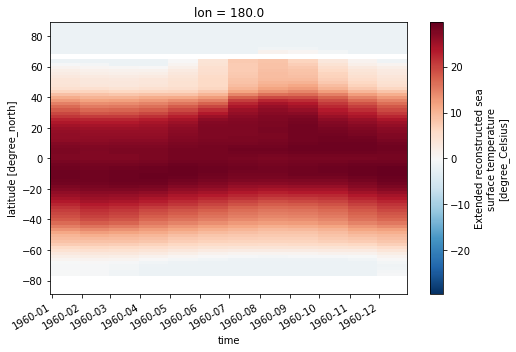

In [20]:
sst.sel(lon=180).transpose().plot()

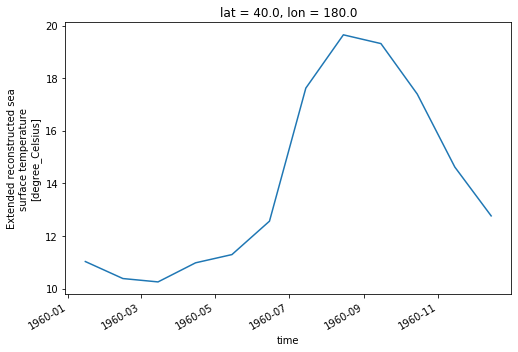

In [21]:
sst.sel(lon=180, lat=40).plot()

### Label-Based Reduction Operations

Usually the process of data analysis involves going from a big, multidimensional dataset to a few concise figures.
Inevitably, the data must be "reduced" somehow. Examples of simple reduction operations include:

- Mean
- Standard Deviation
- Minimum
- Maximum

etc. Xarray supports all of these and more, via a familiar numpy-like syntax. But with xarray, you can specify the reductions by dimension.

First we start with the default, reduction over all dimensions:

In [22]:
sst.mean()

<xarray.DataArray 'sst' ()>
array(13.626506, dtype=float32)

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


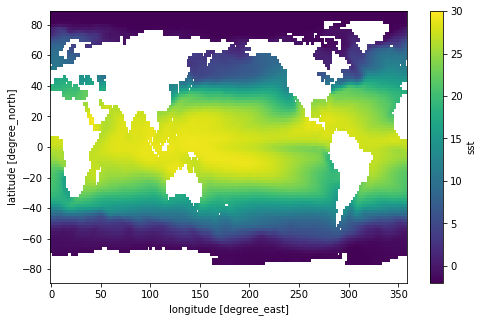

In [23]:
sst_time_mean = sst.mean(dim='time')
sst_time_mean.plot(vmin=-2, vmax=30)

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


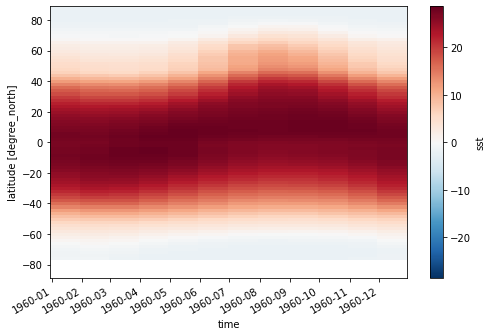

In [24]:
sst_zonal_mean = sst.mean(dim='lon')
sst_zonal_mean.transpose().plot()

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


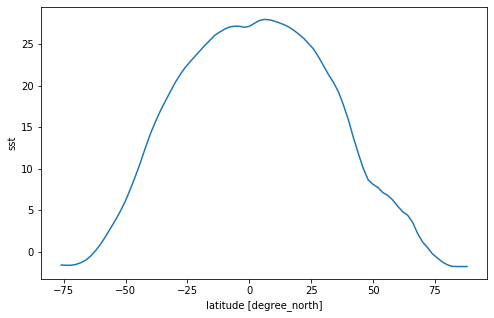

In [25]:
sst_time_and_zonal_mean = sst.mean(dim=('time', 'lon'))
sst_time_and_zonal_mean.plot()

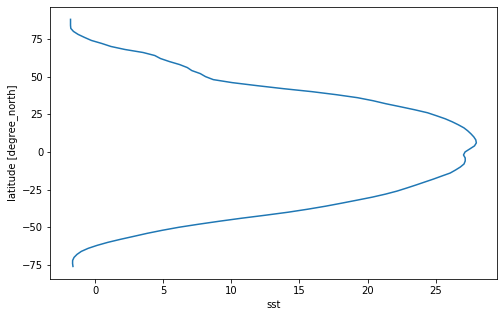

In [26]:
# some might prefer to have lat on the y axis
sst_time_and_zonal_mean.plot(y='lat')

### More Complicated Example: Weighted Mean

The means we calculated above were "naive"; they were straightforward numerical means over the different dimensions of the dataset. They did not account, for example, for spherical geometry of the globe and the necessary weighting factors. Although xarray is very useful for geospatial analysis, **it has no built-in understanding of geography**.

Below we show how to create a proper weighted mean by using the formula for the area element in spherical coordinates. This is a good illustration of several xarray concepts.

The [area element for lat-lon coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system#Integration_and_differentiation_in_spherical_coordinates) is

$$ \delta A = R^2 \delta \phi \delta \lambda \cos(\phi) $$

where $\phi$ is latitude, $\delta \phi$ is the spacing of the points in latitude, $\delta \lambda$ is the spacing of the points in longitude, and $R$ is Earth's radius. (In this formula, $\phi$ and $\lambda$ are measured in radians.) Let's use xarray to create the weight factor.

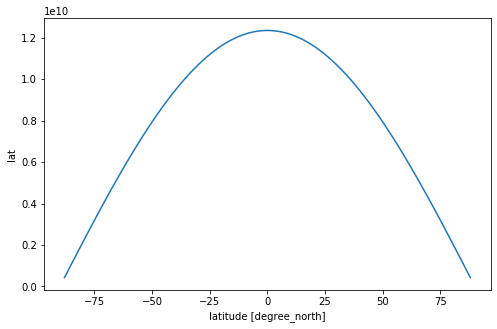

In [27]:
R = 6.37e6
# we know already that the spacing of the points is one degree latitude
dϕ = np.deg2rad(1.)
dλ = np.deg2rad(1.)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat))
dA.plot()

In [28]:
dA.where(sst[0].notnull())

<xarray.DataArray 'lat' (lat: 89, lon: 180)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [1.2920163e+09, 1.2920163e+09, 1.2920163e+09, ..., 1.2920163e+09,
        1.2920163e+09, 1.2920163e+09],
       [8.6222048e+08, 8.6222048e+08, 8.6222048e+08, ..., 8.6222048e+08,
        8.6222048e+08, 8.6222048e+08],
       [4.3137280e+08, 4.3137280e+08, 4.3137280e+08, ..., 4.3137280e+08,
        4.3137280e+08, 4.3137280e+08]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    time     datetime64[ns] 1960-01-15

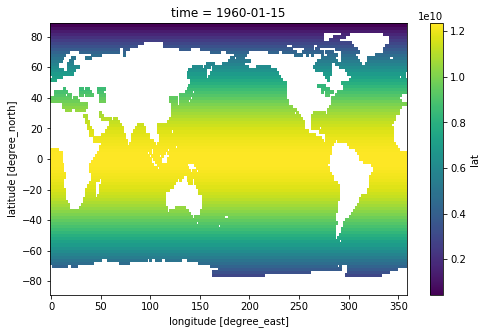

In [29]:
pixel_area = dA.where(sst[0].notnull())
pixel_area.plot()

In [30]:
pixel_area.sum(dim=('lon','lat'))

<xarray.DataArray 'lat' ()>
array(9.343151e+13, dtype=float32)
Coordinates:
    time     datetime64[ns] 1960-01-15

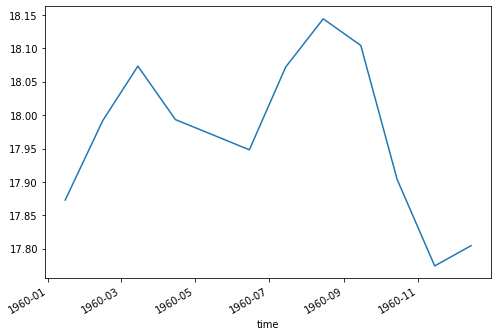

In [31]:
total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
sst_weighted_mean = (sst * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
sst_weighted_mean.plot()

### Exercise

Find the maximum temperature in a box spanning the coordinates

- lon: 150 - 200
- lat: 20N - 30N

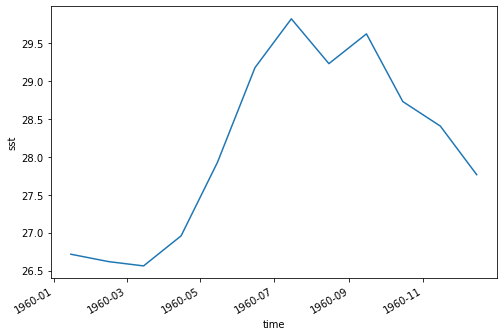

In [32]:
sst.sel(lon=slice(150,200), lat=slice(20,30)).max(dim=('lat','lon')).plot()

## IV. Opening Many Files

One of the killer features of xarray is its ability to open many files into a single dataset. We do this with the `open_mfdataset` function.

In [33]:
ds_all = xr.open_mfdataset('/root/.xarray_tutorial_data/sst/*nc', combine='by_coords')
ds_all

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 89, 180), meta=np.ndarray>
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

Now we have 57 years of data instead of one!

## V. Groupby

Now that we have a bigger dataset, this is a good time to check out xarray's groupby capabilities.

In [34]:
sst_clim = ds_all.sst.groupby('time.month').mean(dim='time')
sst_clim

<xarray.DataArray 'sst' (month: 12, lat: 89, lon: 180)>
dask.array<transpose, shape=(12, 89, 180), dtype=float32, chunksize=(1, 89, 180)>
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Now the data has dimension `month` instead of time!
Each value represents the average among all of the Januaries, Februaries, etc. in the dataset.

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'June minus January SST Climatology')

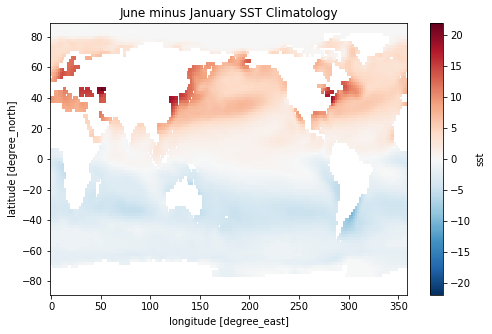

In [35]:
(sst_clim[6] - sst_clim[0]).plot()
plt.title('June minus January SST Climatology')

## VI. Resample and Rolling

Resample is meant specifically to work with time data (data with a `datetime64` variable as a dimension).
It allows you to change the time-sampling frequency of your data.

Let's illustrate by selecting a single point.

In [36]:
sst_ts = ds_all.sst.sel(lon=300, lat=10)
sst_ts_annual = sst_ts.resample(time='A').mean(dim='time')
sst_ts_annual

<xarray.DataArray 'sst' (time: 57)>
dask.array<stack, shape=(57,), dtype=float32, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 1960-12-31 1961-12-31 ... 2016-12-31
    lat      float32 10.0
    lon      float32 300.0

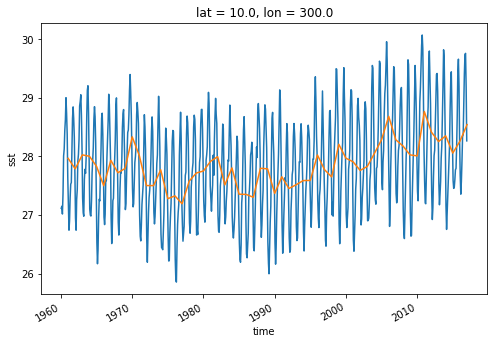

In [37]:
sst_ts.plot()
sst_ts_annual.plot()

To specify different resampling frequency, check out the [Offset aliases](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) for the string aliases to use.

To know more about the various resampling methods xarray supports, check out the documentation on [Resampling and grouped operations](http://xarray.pydata.org/en/stable/time-series.html#resampling-and-grouped-operations).

An alternative approach is a "running mean" over the time dimension.
This can be accomplished with xarray's `.rolling` operation.

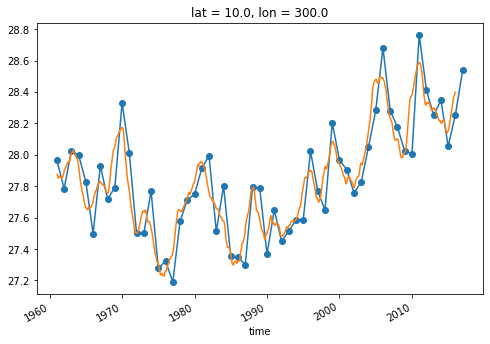

In [38]:
sst_ts_rolling = sst_ts.rolling(time=24, center=True).mean()
sst_ts_annual.plot(marker='o')
sst_ts_rolling.plot()

## Finale: Calculate the ENSO Index

[This page from NOAA](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst) explains how the El Niño Southern Oscillation index is calculated.


- The Nino 3.4 region is defined as the region between +/- 5 deg. lat, 170 W - 120 W lon.
- Warm or cold phases of the Oceanic Nino Index are defined by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). This is known as the Oceanic Niño Index (ONI).

(Note that "anomaly" means that the seasonal cycle is removed.)

_Try working on this on your own for 5 minutes._

Once you're done, try comparing the ENSO Index you calculated with the NINO3.4 index published by [NOAA](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/). The pandas snippit below will load the official time series for comparison.

In [39]:
import pandas as pd
noaa_nino34 = pd.read_csv('https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices',
                          sep=r" ", skipinitialspace=True,
                          parse_dates={'time': ['YR','MON']},
                          index_col='time')['NINO3.4']
noaa_nino34.head()

time
1982-01-01    26.72
1982-02-01    26.70
1982-03-01    27.20
1982-04-01    28.02
1982-05-01    28.54
Name: NINO3.4, dtype: float64